# CIVE 650 — Assignment 4

In [28]:
# import necessary modules 
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
from tensorly.decomposition import parafac, tucker
from tensorly import tensor, tucker_to_tensor, cp_to_tensor
import warnings
import pandas as pd
import os, gc
import json
TENSORLY_AVAILABLE = True

2D train shape: (323, 1440), GT shape: (323, 1440)
Missing ratio (2D train): 19.97%


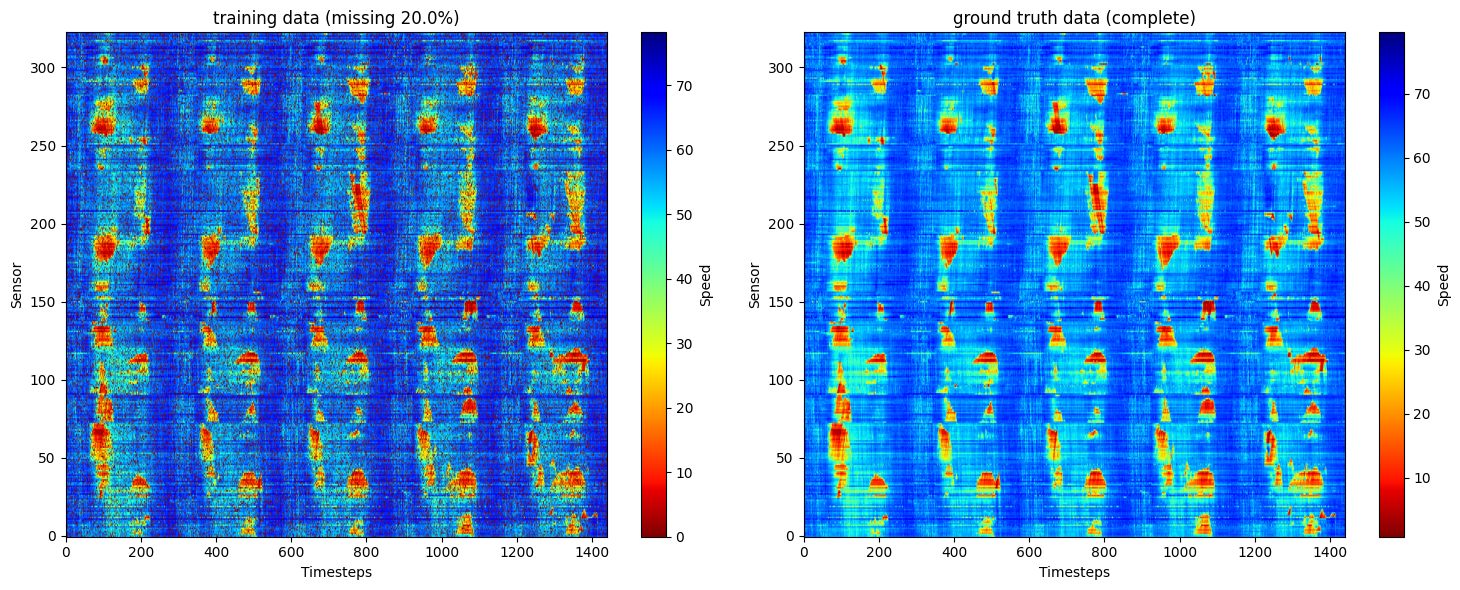

In [29]:
# loading datasets 
data = sio.loadmat('traffc_speed.mat')
train = data['train']  # training data with missing values (0 indicates missing)
ground_truth = data['ground_truth']  # ground truth data 

# replace 0 with NaN and print the shape and missing value ratio
train[train == 0] = np.nan
print(f"2D train shape: {train.shape}, GT shape: {ground_truth.shape}")
print(f"Missing ratio (2D train): {np.isnan(train).sum() / train.size * 100:.2f}%")

# missing value mask
missing_mask = np.isnan(train)
valid_mask = ~missing_mask

# visualize data information 
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# 1. Training data heatmap
train_vis = train.copy()
train_vis[np.isnan(train_vis)] = 0
im1 = axes[0].imshow(train_vis, aspect='auto', cmap='jet_r', origin='lower')
axes[0].set_xlabel('Timesteps')
axes[0].set_ylabel('Sensor')
axes[0].set_title(f'training data (missing {np.isnan(train).sum()/train.size*100:.1f}%)')
plt.colorbar(im1, ax=axes[0], label='Speed')

# 2. True data heatmap
im2 = axes[1].imshow(ground_truth, aspect='auto', cmap='jet_r', origin='lower')
axes[1].set_xlabel('Timesteps')
axes[1].set_ylabel('Sensor')
axes[1].set_title('ground truth data (complete)')
plt.colorbar(im2, ax=axes[1], label='Speed')

plt.tight_layout()
plt.show()

## Question1

3D train_tensor shape: (323, 288, 5)
3D gt_tensor shape: (323, 288, 5)
Missing ratio (3D train): 19.97%


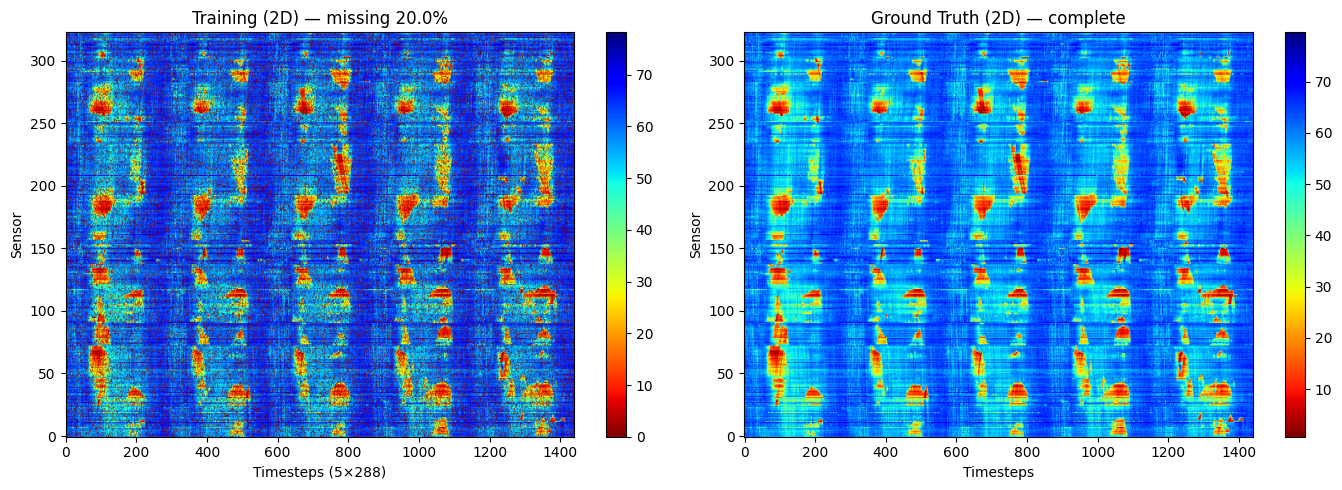

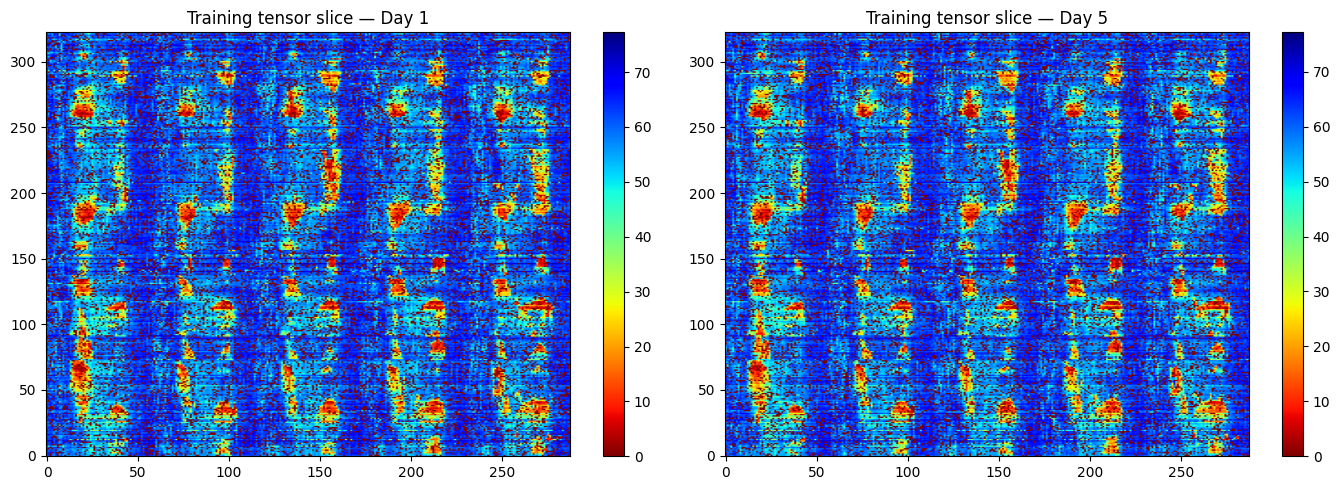

In [ ]:
# make the matrix into a 3-order tensor
# original matrix: (323, 1440) = (sensors, total timestamps)
# 1440 = 5 days × 288 timestamps/day
# reshape to: (323, 288, 5) = (sensors, timestamps, days)

n_sensors = 323  # number of sensors
n_timestamps_per_day = 288  # number of timestamps per day 1440 // 5 = 288
n_days = 5  # number of days

# reshape the training data into a tensor
train_tensor = train.reshape(n_sensors, n_timestamps_per_day, n_days)
gt_tensor = ground_truth.reshape(n_sensors, n_timestamps_per_day, n_days)

print("3D train_tensor shape:", train_tensor.shape)  # (323, 288, 5)
print("3D gt_tensor shape:", gt_tensor.shape)
print(f"Missing ratio (3D train): {np.isnan(train_tensor).sum()/train_tensor.size*100:.2f}%")

# visualization
fig, axes = plt.subplots(1, 2, figsize=(14,5))
im1 = axes[0].imshow(np.nan_to_num(train, nan=0.0), aspect='auto', cmap='jet_r', origin='lower')
axes[0].set_title(f"Training (2D) — missing {np.isnan(train).sum()/train.size*100:.1f}%")
axes[0].set_xlabel('Timesteps (5×288)'); axes[0].set_ylabel('Sensor'); plt.colorbar(im1, ax=axes[0])

im2 = axes[1].imshow(ground_truth, aspect='auto', cmap='jet_r', origin='lower')
axes[1].set_title("Ground Truth (2D) — complete")
axes[1].set_xlabel('Timesteps'); axes[1].set_ylabel('Sensor'); plt.colorbar(im2, ax=axes[1])
plt.tight_layout(); plt.show()

# tensor slice visualization
fig, axes = plt.subplots(1, 2, figsize=(14,5))
im1 = axes[0].imshow(np.nan_to_num(train_tensor[:,:,0], nan=0.0), aspect='auto', cmap='jet_r', origin='lower')
axes[0].set_title("Training tensor slice — Day 1"); plt.colorbar(im1, ax=axes[0])
im2 = axes[1].imshow(np.nan_to_num(train_tensor[:,:,-1], nan=0.0), aspect='auto', cmap='jet_r', origin='lower')
axes[1].set_title("Training tensor slice — Day 5"); plt.colorbar(im2, ax=axes[1])
plt.tight_layout(); plt.show()


## Question 2

In [31]:
# limit CPU threads to prevent oversubscription
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"

# mask & missing idx
mask_valid_3d  = ~np.isnan(train_tensor)       # bool mask
miss_idx_3d    = np.where(~mask_valid_3d)      # test set = train missing
gt_miss        = gt_tensor[miss_idx_3d]

# initialize X_init with mean imputation
mean_val = float(np.nanmean(train_tensor)) if np.isfinite(np.nanmean(train_tensor)) else 0.0
X_init   = np.nan_to_num(train_tensor, nan=mean_val).astype(np.float32)

# TensorLy settings: disable SVD initialization, shorten iterations
try:
    import tensorly as tl
    from tensorly.decomposition import parafac # for CP decomposition
    from tensorly.cp_tensor import cp_to_tensor # for reconstructing full tensor from CP factors
    tl.set_backend('numpy')
    USING_TENSORLY = True
    print("TensorLy available (backend=numpy).") 
except Exception as e:
    USING_TENSORLY = False
    print("TensorLy not available. Install tensorly to run CP with mask.")
    print("Reason:", repr(e))

# CP decomposition with missing values using TensorLy
def cp_masked(X_init, mask_bool, rank, init_factors=None, n_iter_max=60, tol=1e-5):

    init_kw = 'random' if init_factors is None else init_factors
    kruskal = parafac(
        X_init,
        rank=rank,
        init=init_kw,                 # avoid 'svd' heavy unfolding SVD
        mask=mask_bool,               # bool: True=observed
        n_iter_max=n_iter_max,
        tol=tol,
        normalize_factors=True,
        linesearch=False,             # reduce complexity
        verbose=False,
    )
    return cp_to_tensor(kruskal), kruskal

TensorLy available (backend=numpy).



=== CP rank = 10 ===
RMSE on missing entries: 5.3612


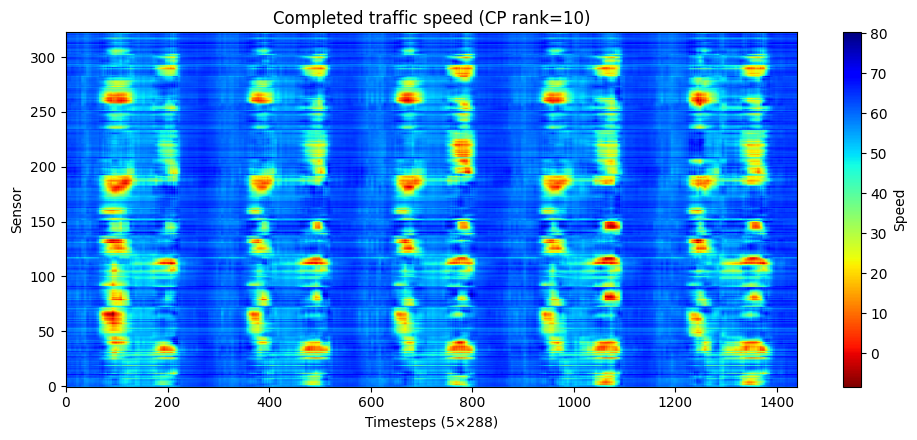


=== CP rank = 20 ===
RMSE on missing entries: 4.7839


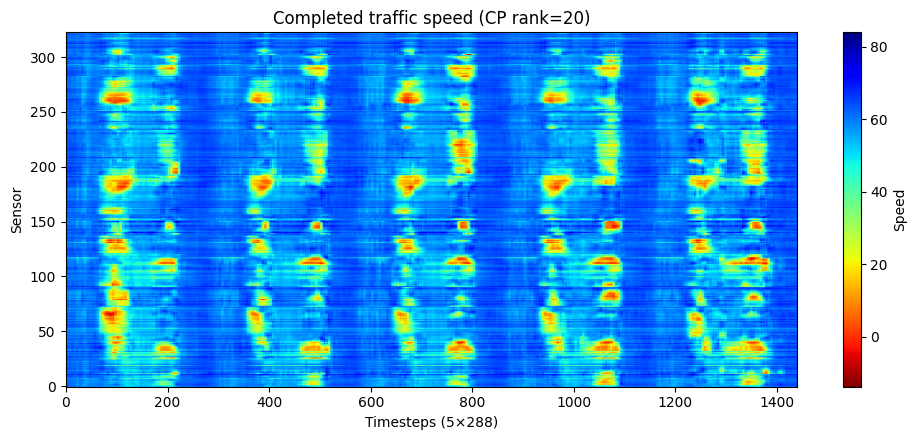


=== CP rank = 50 ===
RMSE on missing entries: 4.1289


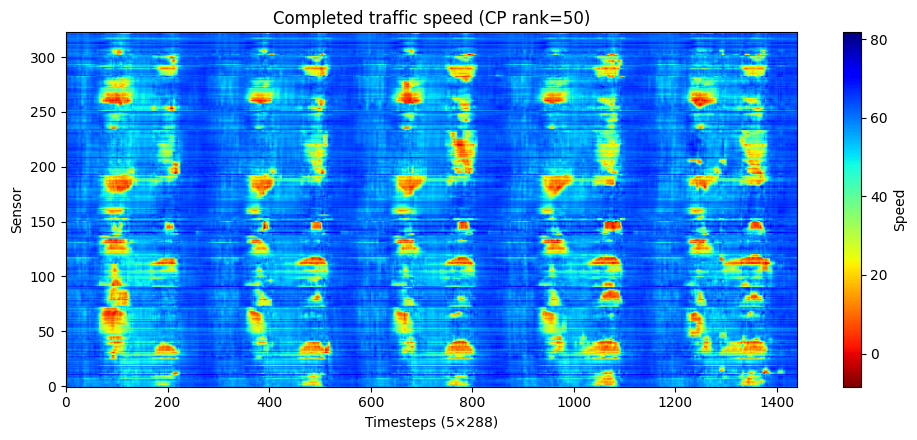


Summary RMSE (missing entries): {10: 5.36117301631869, 20: 4.783855310773199, 50: 4.1288637790948375}


In [32]:
# main CP runs with different ranks
ranks = [10, 20, 50]
results_rmse = {}
init_for_next = None  # for hot start

if USING_TENSORLY:
    for r in ranks:
        print(f"\n=== CP rank = {r} ===")
        Xhat, kr = cp_masked(X_init, mask_valid_3d, rank=r, init_factors=init_for_next,
                             n_iter_max=60, tol=1e-5)
        init_for_next = None

        pred_miss = Xhat[miss_idx_3d]
        rmse_miss = float(np.sqrt(np.mean((pred_miss - gt_miss)**2)))
        results_rmse[r] = rmse_miss
        print(f"RMSE on missing entries: {rmse_miss:.4f}")

        # visualization
        Xhat_2d = Xhat.reshape(n_sensors, n_timestamps_per_day * n_days)
        plt.figure(figsize=(10,4.5))
        plt.imshow(Xhat_2d, aspect='auto', origin='lower', cmap='jet_r')
        plt.title(f'Completed traffic speed (CP rank={r})')
        plt.xlabel('Timesteps (5×288)'); plt.ylabel('Sensor')
        plt.colorbar(label='Speed')
        plt.tight_layout(); plt.show()

        # clean up to save memory
        del Xhat, kr; gc.collect()
else:
    print("Skip CP runs: TensorLy not available.")

print("\nSummary RMSE (missing entries):", results_rmse)


## Question3


In [33]:
# Tucker decomposition with EM for missing data 
def tucker_em_completion(X_init, mask_bool, ranks, em_iters=6, n_iter_max=40, tol=1e-5):
    import tensorly as tl
    
    Xw = X_init.copy().astype(np.float32)
    
    for _ in range(em_iters):
        # Tucker decomposition on the current estimate
        tkr = tl.decomposition.tucker(Xw, rank=ranks, init='random', n_iter_max=n_iter_max)
        
        # Reconstruct the tensor
        Xh = tl.tucker_to_tensor(tkr).astype(np.float32)

        # EM core step: only update missing values
        Xw[~mask_bool] = Xh[~mask_bool]
    
    return Xh


=== Tucker ranks = (30, 20, 3) ===


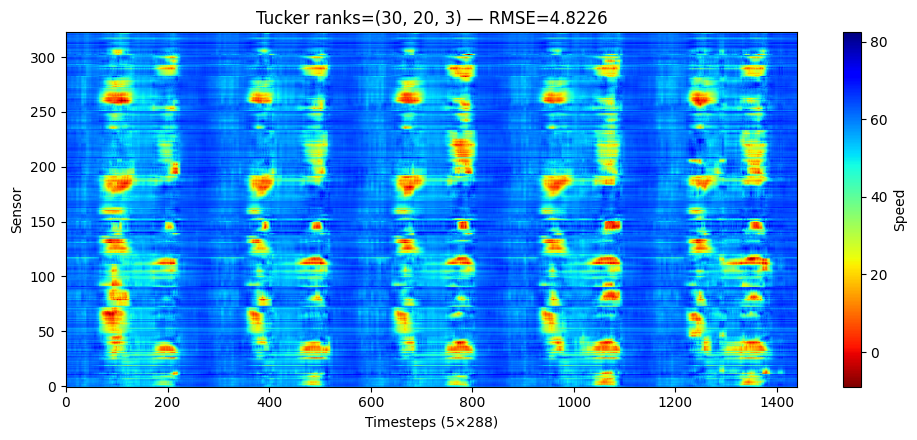


=== Tucker ranks = (40, 30, 3) ===


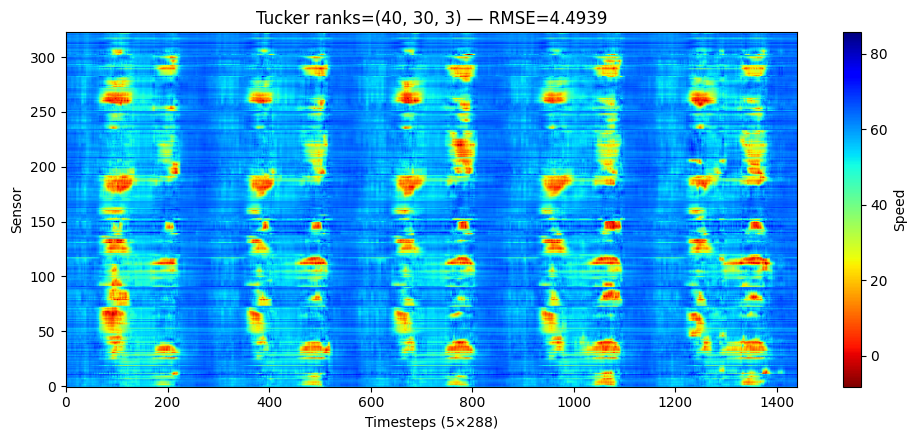


=== Tucker ranks = (50, 40, 3) ===


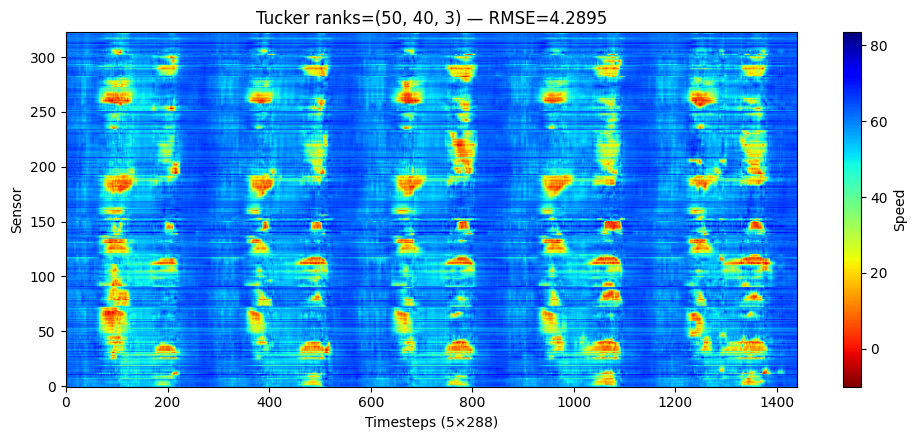


=== Tucker ranks = (40, 30, 4) ===


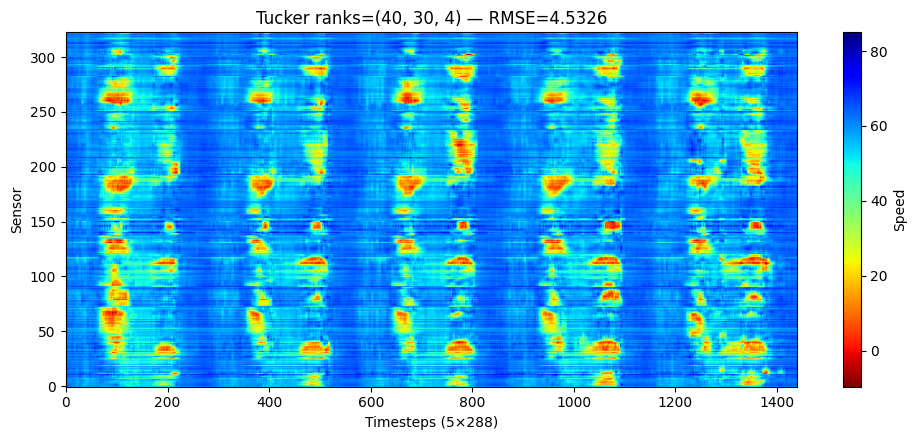


Summary RMSE (Tucker, missing entries): {(30, 20, 3): 4.822617527363796, (40, 30, 3): 4.4939064434592515, (50, 40, 3): 4.289533827117937, (40, 30, 4): 4.5325822956609425}
Best ranks: (50, 40, 3) with RMSE: 4.289533827117937

Tucker RMSE Table:
   Tucker ranks  RMSE (missing)
2  (50, 40, 3)        4.289534
1  (40, 30, 3)        4.493906
3  (40, 30, 4)        4.532582
0  (30, 20, 3)        4.822618
Saved: q3_tucker_rmse.json, q3_tucker_rmse.csv


In [34]:
# run Tucker with different ranks 

ranks_list = [(30,20,3), (40,30,3), (50,40,3), (40,30,4)]
results, best = {}, (None, np.inf)

# main Tucker runs 
if USING_TENSORLY:
    for ranks in ranks_list:
        print(f"\n=== Tucker ranks = {ranks} ===")
        Xhat = tucker_em_completion(X_init, mask_valid_3d, ranks=ranks,
                                    em_iters=6, n_iter_max=40, tol=1e-5)
        rmse = float(np.sqrt(np.mean((Xhat[miss_idx_3d] - gt_miss)**2)))
        results[ranks] = rmse
        if rmse < best[1]: best = (ranks, rmse)

        X2d = Xhat.reshape(n_sensors, n_timestamps_per_day*n_days)
        plt.figure(figsize=(10,4.5))
        plt.imshow(X2d, aspect='auto', origin='lower', cmap='jet_r')
        plt.title(f'Tucker ranks={ranks} — RMSE={rmse:.4f}')
        plt.xlabel('Timesteps (5×288)'); plt.ylabel('Sensor')
        plt.colorbar(label='Speed'); plt.tight_layout(); plt.show(); plt.close()
        del Xhat, X2d; gc.collect()
else:
    print("Skip Tucker runs.")

# save results 
print("\nSummary RMSE (Tucker, missing entries):", results)
print("Best ranks:", best[0], "with RMSE:", best[1] if np.isfinite(best[1]) else None)
if results:
    df = pd.DataFrame([(str(k), v) for k,v in results.items()],
                      columns=["Tucker ranks","RMSE (missing)"]).sort_values("RMSE (missing)")
    print("\nTucker RMSE Table:\n", df)
    with open('q3_tucker_rmse.json','w') as f: json.dump({str(k):float(v) for k,v in results.items()}, f, indent=2)
    df.to_csv('q3_tucker_rmse.csv', index=False)
    print("Saved: q3_tucker_rmse.json, q3_tucker_rmse.csv")
# =======================================================================


## Question4

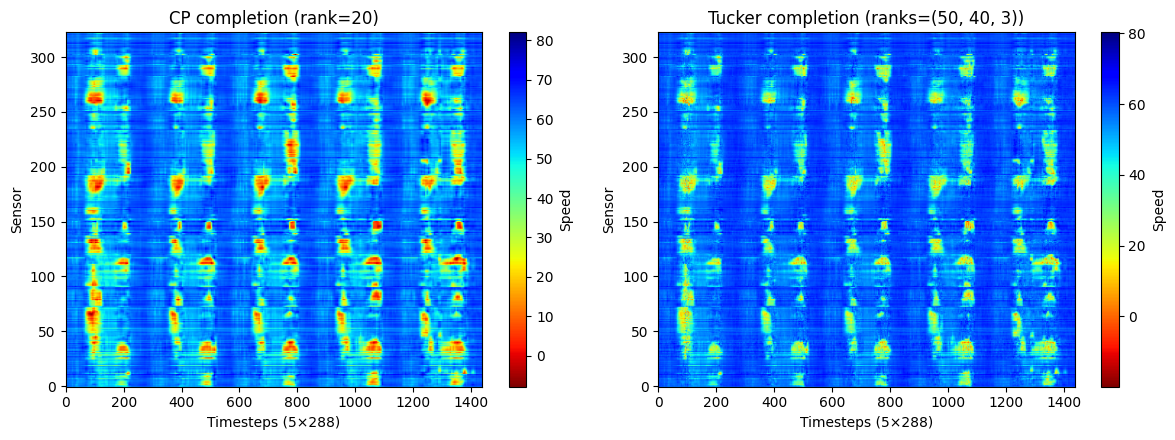

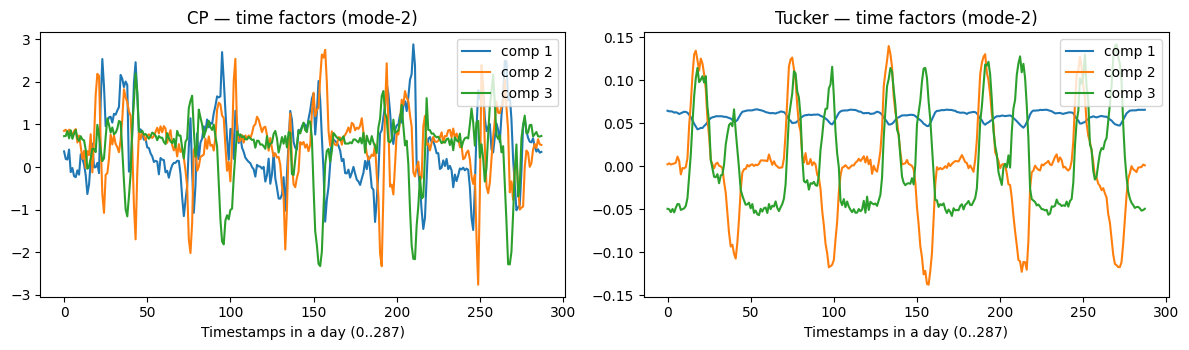

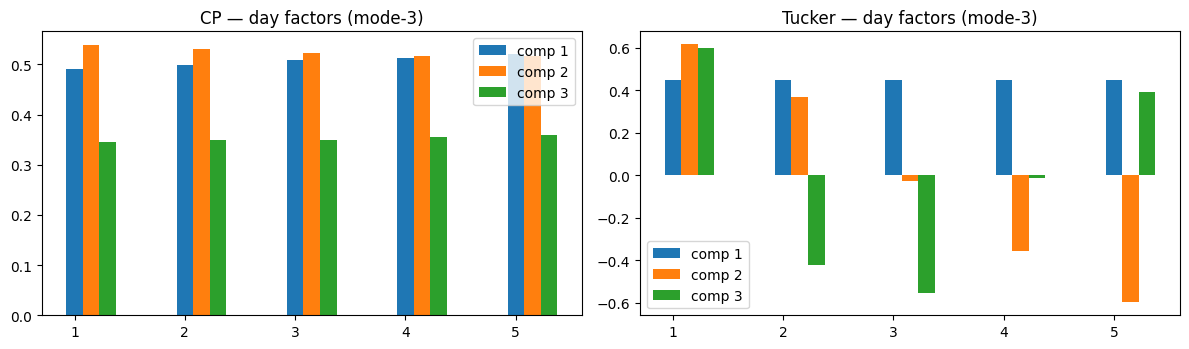

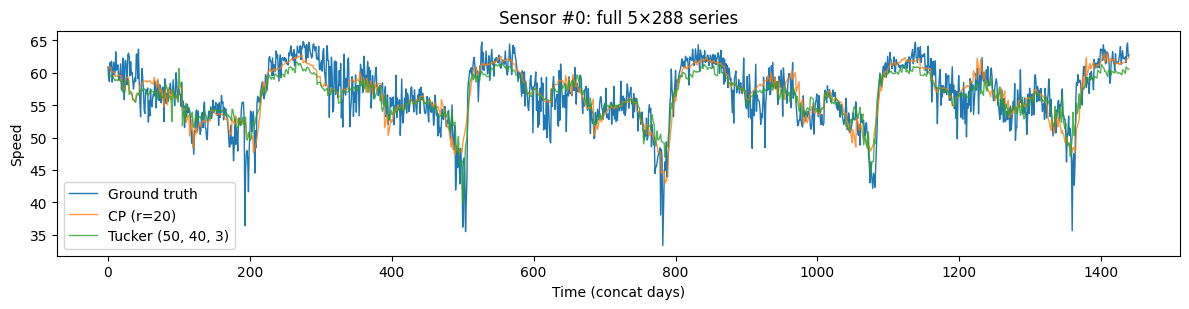

In [35]:
# data preparation
mask_obs = ~np.isnan(train_tensor)  # True=observed
X_init   = np.nan_to_num(train_tensor, nan=float(np.nanmean(train_tensor))).astype(np.float32)


# ---------- Fit CP (rank=20) ----------
import tensorly as tl
from tensorly.decomposition import parafac
tl.set_backend('numpy')

cp_rank = 20
cp_kr = parafac(
    X_init, rank=cp_rank, init='random',
    mask=mask_obs, n_iter_max=50, tol=1e-5, verbose=False
)
X_cp = tl.cp_to_tensor(cp_kr).astype(np.float32)
# CP （A: sensors × r, B: time × r, C: days × r）
try:
    A_cp, B_cp, C_cp = cp_kr.factors
except AttributeError:
    A_cp, B_cp, C_cp = cp_kr[1] # returns (weights,factors)

# ---------- Fit Tucker (ranks=(50,40,3)) ----------
from tensorly.decomposition import tucker as tucker_fn

tucker_ranks = (50, 40, 3)  # (sensors, time, days)
import inspect
params = set(inspect.signature(tucker_fn).parameters)
kwargs = {'init':'random', 'n_iter_max':50}
if 'tol' in params: kwargs['tol'] = 1e-5
if 'rank' in params:
    core_tk, factors_tk = tucker_fn(X_init, rank=tucker_ranks, **kwargs)
else:
    core_tk, factors_tk = tucker_fn(X_init, ranks=tucker_ranks, **kwargs)

X_tk = tl.tucker_to_tensor((core_tk, factors_tk)).astype(np.float32)
A_tk, B_tk, C_tk = factors_tk  # shapes: (323×r1), (288×r2), (5×r3)

# ---------- Heatmaps: CP vs Tucker ----------
X_cp_2d = X_cp.reshape(n_sensors, n_timestamps_per_day * n_days)
X_tk_2d = X_tk.reshape(n_sensors, n_timestamps_per_day * n_days)

fig, axes = plt.subplots(1, 2, figsize=(12,4.5))
im1 = axes[0].imshow(X_cp_2d, aspect='auto', origin='lower', cmap='jet_r')
axes[0].set_title(f'CP completion (rank={cp_rank})')
axes[0].set_xlabel('Timesteps (5×288)'); axes[0].set_ylabel('Sensor')
plt.colorbar(im1, ax=axes[0], label='Speed')

im2 = axes[1].imshow(X_tk_2d, aspect='auto', origin='lower', cmap='jet_r')
axes[1].set_title(f'Tucker completion (ranks={tucker_ranks})')
axes[1].set_xlabel('Timesteps (5×288)'); axes[1].set_ylabel('Sensor')
plt.colorbar(im2, ax=axes[1], label='Speed')
plt.tight_layout(); plt.show()

# ----------Temporal factors (Mode-2): first 3 components ----------
k_show = 3
t = np.arange(n_timestamps_per_day)

fig, axes = plt.subplots(1, 2, figsize=(12,3.6))
for k in range(min(k_show, B_cp.shape[1])):
    axes[0].plot(t, B_cp[:, k], lw=1.5, label=f'comp {k+1}')
axes[0].set_title('CP — time factors (mode-2)')
axes[0].set_xlabel('Timestamps in a day (0..287)'); axes[0].legend(loc='upper right')

for k in range(min(k_show, B_tk.shape[1])):
    axes[1].plot(t, B_tk[:, k], lw=1.5, label=f'comp {k+1}')
axes[1].set_title('Tucker — time factors (mode-2)')
axes[1].set_xlabel('Timestamps in a day (0..287)'); axes[1].legend(loc='upper right')
plt.tight_layout(); plt.show()

# ---------- Day factors (Mode-3): first 3 components ----------
days = np.arange(1, n_days+1)

fig, axes = plt.subplots(1, 2, figsize=(12,3.6))
for k in range(min(k_show, C_cp.shape[1])):
    axes[0].bar(days + 0.15*k, C_cp[:, k], width=0.15, label=f'comp {k+1}')
axes[0].set_xticks(days); axes[0].set_title('CP — day factors (mode-3)'); axes[0].legend()

for k in range(min(k_show, C_tk.shape[1])):
    axes[1].bar(days + 0.15*k, C_tk[:, k], width=0.15, label=f'comp {k+1}')
axes[1].set_xticks(days); axes[1].set_title('Tucker — day factors (mode-3)'); axes[1].legend()
plt.tight_layout(); plt.show()

# ---------- 6) one-sensor time series: GT vs CP vs Tucker ----------
sensor_id = 0  
gt_full = gt_tensor[sensor_id].reshape(-1)
cp_full = X_cp[sensor_id].reshape(-1)
tk_full = X_tk[sensor_id].reshape(-1)

plt.figure(figsize=(12,3.2))
plt.plot(gt_full, lw=1, label='Ground truth')
plt.plot(cp_full, lw=1, alpha=0.8, label=f'CP (r={cp_rank})')
plt.plot(tk_full, lw=1, alpha=0.8, label=f'Tucker {tucker_ranks}')
plt.title(f'Sensor #{sensor_id}: full 5×288 series')
plt.xlabel('Time (concat days)'); plt.ylabel('Speed'); plt.legend()
plt.tight_layout(); plt.show()
